In [11]:
#link dataset: https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant
#nume fisier dataset: CombinedCyclePowerPlant.csv
#● Chase demand(for seasonality, forecasting the energy output, capacity management)

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import plotly.offline as py
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from prettytable import PrettyTable 
from scipy.stats import pearsonr

import itertools
import statsmodels.api as sm
from pylab import rcParams

warnings.filterwarnings("ignore")

In [3]:
# importare si afisare set de date din fisierul csv
df = pd.read_csv('CombinedCyclePowerPlant.csv')
print(f"Forma setului de date: {df.shape}")
print(df.head(5))
print(f"Exista {len(df)} date inregistrate(timp de 6 ani: 2006-2011), cate o inregistrare la aproximativ 6ore!")
print("""
Features consist of hourly average ambient variables:
   - Ambient Temperature (AT) in the range 1.81°C and 37.11°C,
   - Ambient Pressure (AP) in the range 992.89–1033.30 millibar,
   - Relative Humidity (RH) in the range of 25.56% to 100.16%
   - Exhaust Vacuum (V) in the range 25.36–81.56 cm Hg
   - Net hourly electrical energy output (PE) 420.26–495.76 MW
""")

Forma setului de date: (9568, 5)
      AT      V       AP     RH      PE
0   8.34  40.77  1010.84  90.01  480.48
1  23.64  58.49  1011.40  74.20  445.75
2  29.74  56.90  1007.15  41.91  438.76
3  19.07  49.69  1007.22  76.79  453.09
4  11.80  40.66  1017.13  97.20  464.43
Exista 9568 date inregistrate(timp de 6 ani: 2006-2011), cate o inregistrare la aproximativ 6ore!

Features consist of hourly average ambient variables:
   - Ambient Temperature (AT) in the range 1.81°C and 37.11°C,
   - Ambient Pressure (AP) in the range 992.89–1033.30 millibar,
   - Relative Humidity (RH) in the range of 25.56% to 100.16%
   - Exhaust Vacuum (V) in the range 25.36–81.56 cm Hg
   - Net hourly electrical energy output (PE) 420.26–495.76 MW



<AxesSubplot:>

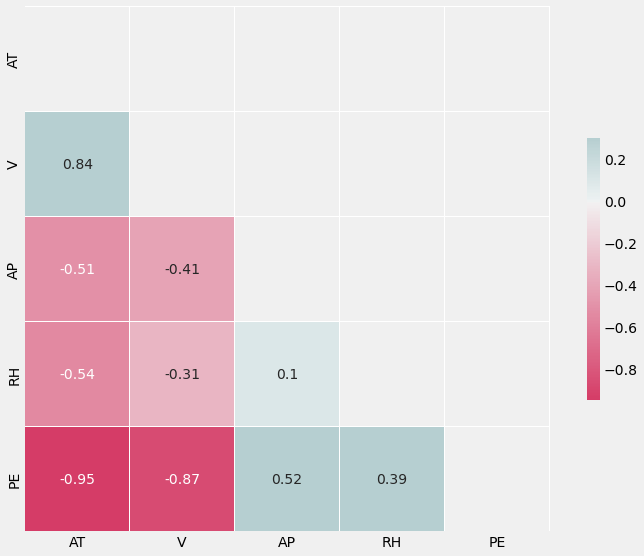

In [4]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(1,200, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot  = True)

- Power(PE) has a strong negative correlation with 'Ambient Temperature'(AT) and 'Exhaust Vacuum'(EV) of the Plant. So, it seems that as Temperature or Vacuum increases the Power output of the Plant decreases.
- Similarly, Power has a positive correlation with Pressure and Humidity. It seems that on increasing Humidity and Pressure, the Power output will increase.
- Vacuum has a strong positive correlation with Temperature of the plant and also Humidity has a small positive correlation with Pressure.
- All the other non Power linkages have a negative correlation.

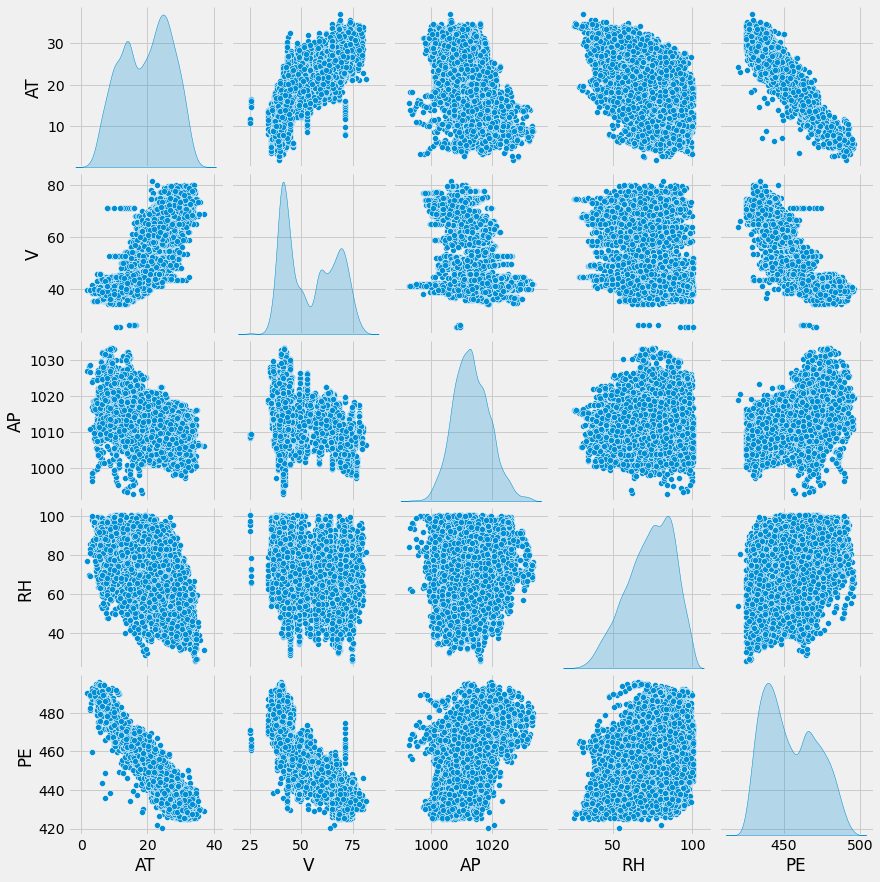

In [5]:
sns.pairplot(df, diag_kind='kde')

In [6]:
# Adaugare coloana de datetime pentru forecasting
dti = pd.date_range("2006-01-01", periods=9568, freq="5.496H")
df_new = df
df_new['Date'] = dti
print(df_new.head())

      AT      V       AP     RH      PE                    Date
0   8.34  40.77  1010.84  90.01  480.48 2006-01-01 00:00:00.000
1  23.64  58.49  1011.40  74.20  445.75 2006-01-01 05:29:45.600
2  29.74  56.90  1007.15  41.91  438.76 2006-01-01 10:59:31.200
3  19.07  49.69  1007.22  76.79  453.09 2006-01-01 16:29:16.800
4  11.80  40.66  1017.13  97.20  464.43 2006-01-01 21:59:02.400


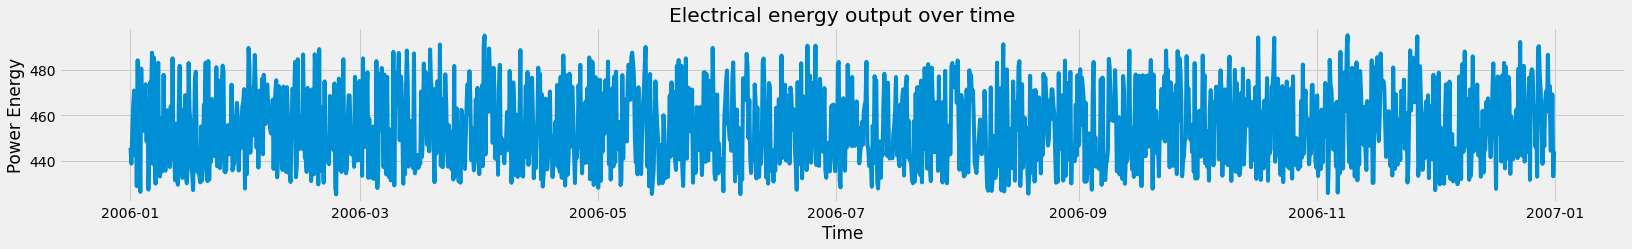

In [7]:
plt.rcParams["figure.figsize"] = (25,3)
plt.plot(df_new[(df_new['Date'] > '2006-01-01') & (df_new['Date'] <= '2007-01-01')]['Date'], df_new[(df_new['Date'] > '2006-01-01') & (df_new['Date'] <= '2007-01-01')]['PE'])
plt.xlabel("Time")
plt.ylabel("Power Energy")
plt.title("Electrical energy output over time")
plt.show()

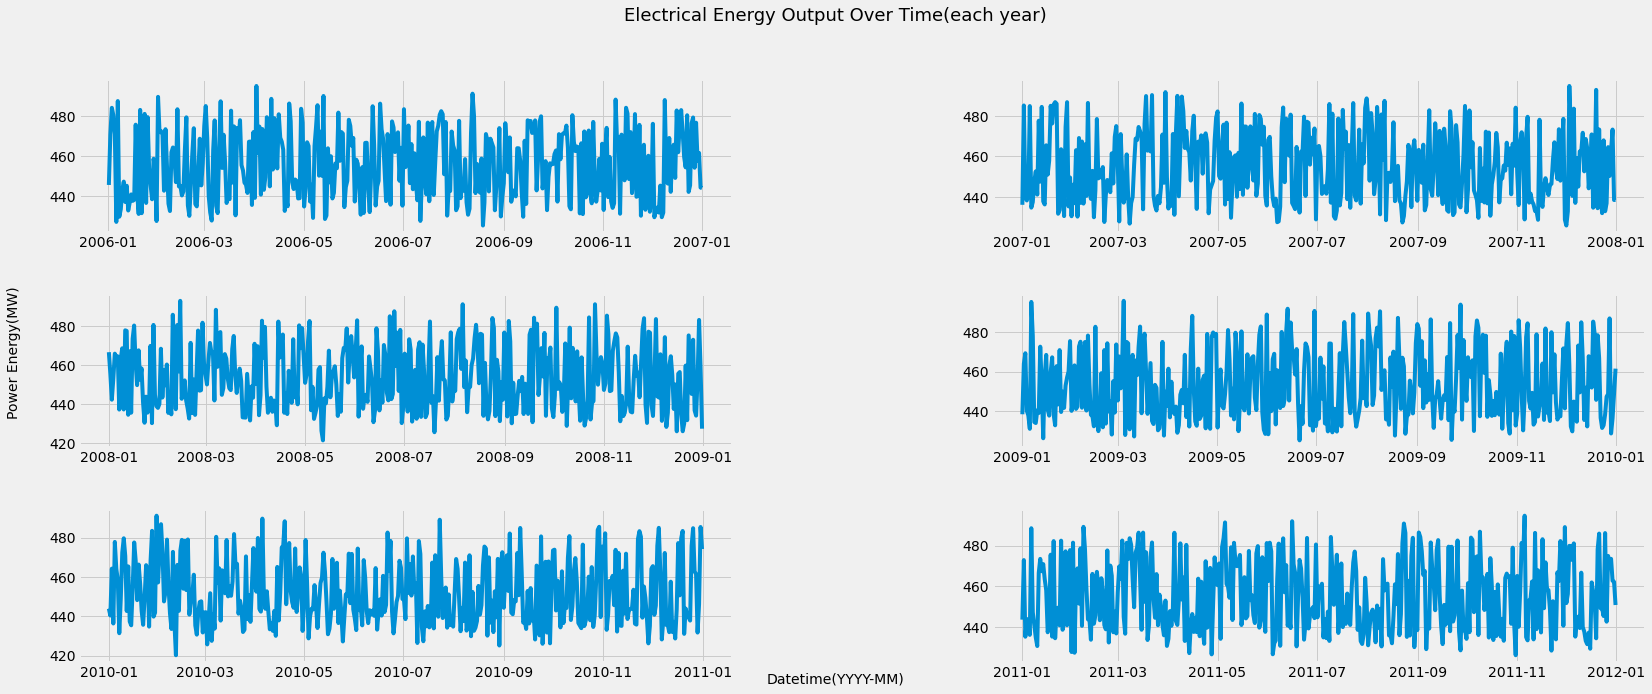

In [8]:
y = 2006
#plt.plot(df_new[(df_new['Date'] > str(y)+'-01-01') & (df_new['Date'] <= str(y+1)+'-01-01')]['Date'], df_new[(df_new['Date'] > str(y)+'-01-01') & (df_new['Date'] <= str(y+1)+'-01-01')]['PE'])

fig = plt.figure(figsize=(25, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle("Electrical Energy Output Over Time(each year)", fontsize=18)
fig.text(0.5, 0.04, 'Datetime(YYYY-MM)', ha='center')
fig.text(0.04, 0.5, 'Power Energy(MW)', va='center', rotation='vertical')
for i in range(1, 7):
    ax = fig.add_subplot(3, 2, i)
    ax.plot(df_new[(df_new['Date'] > str(y)+'-01-01') & (df_new['Date'] <= str(y+1)+'-01-01')]['Date'][::4], df_new[(df_new['Date'] > str(y)+'-01-01') & (df_new['Date'] <= str(y+1)+'-01-01')]['PE'][::4])
    y = y + 1

In [9]:
max_values = []
y = 2006
for i in range(1, 7):
    max_values.append(df_new[(df_new['Date'] > str(y)+'-01-01') & (df_new['Date'] <= str(y+1)+'-01-01')].max())
    y = y + 1

min_values = []
y = 2006
for i in range(1, 7):
    min_values.append(df_new[(df_new['Date'] > str(y)+'-01-01') & (df_new['Date'] <= str(y+1)+'-01-01')].min())
    y = y + 1

min_PE = df_new["PE"].min()
max_PE = df_new["PE"].max()

print(f"MINIMUM VALUES EVER:\n{df_new[df_new['PE']==min_PE]}")
print(f"MAXIMUM VALUES EVER:\n{df_new[df_new['PE']==max_PE]}\n")
print(f"------------MIN VALUES FOR EACH YEAR:\n{min_values}")
print(f"------------MAX VALUES FOR EACH YEAR:\n{max_values}")



MINIMUM VALUES EVER:
         AT      V       AP     RH      PE                Date
6560  24.27  63.87  1018.88  53.96  420.26 2010-02-11 05:45:36
MAXIMUM VALUES EVER:
        AT      V       AP     RH      PE                    Date
5059  5.48  40.07  1019.63  65.62  495.76 2009-03-04 12:15:50.400

------------MIN VALUES FOR EACH YEAR:
[AT                            2.64
V                            25.36
AP                          994.17
RH                           31.45
PE                          425.18
Date    2006-01-01 05:29:45.600000
dtype: object, AT                            2.34
V                            34.03
AP                          993.11
RH                           25.56
PE                          425.34
Date    2007-01-01 00:37:26.400000
dtype: object, AT                            3.74
V                            25.36
AP                          992.89
RH                            26.3
PE                          421.57
Date    2008-01-01 01:14:52.800000


In [12]:
for i in range(df.shape[1]-1):
    feature = df.columns[i]
    X = df[feature].values
    y = df['PE']
    r = np.round(pearsonr(X, y),2)
    print(f"Feature PE vs {feature}: r-value : {r}")

Feature PE vs AT: r-value : [-0.95  0.  ]
Feature PE vs V: r-value : [-0.87  0.  ]
Feature PE vs AP: r-value : [0.52 0.  ]
Feature PE vs RH: r-value : [0.39 0.  ]
Feature PE vs PE: r-value : [1. 0.]


- Feature selection involves selecting the most useful features to train on amongst existing features.
- First, i'll create 4 different combinations of features and train the model with the 3 regression algorithms.

In [13]:
df_1 = df[['AT']] # model1: only AT as the predictor (since it has the strongest correlation with the target variable (PE))
df_2 = df[['AT', 'V']] # model2: AT and V as the predictors
df_3 = df[['AT', 'V', 'RH']] # model3: AT, V and RH as the predictors
df_4 = df[['AT', 'V', 'AP', 'RH']] # model4: AT, V, AP, and RH as the predicto
y = df['PE'] # target variable (PE) is y

- I have decided to use Linear Regression, Decision Tree Regression, and Random Forest Regression algorithms on this dataset.

In [14]:
# DF_1
# split the dataframe into a training and test set
X_train, X_test, y_train, y_test = train_test_split(df_1, y, test_size = 0.2, random_state = 0)

# Linear Regression
regressor1 = LinearRegression()
regressor1.fit(X_train, y_train)
y_pred_lr1 = regressor1.predict(X_test)

# DecisionTree Regressor
dt_regressor1 = DecisionTreeRegressor()
dt_regressor1.fit(X_train, y_train)
y_pred_dtr1 = dt_regressor1.predict(X_test)

# RandomForest Regressor
rf_regressor1 = RandomForestRegressor()
rf_regressor1.fit(X_train, y_train)
y_pred_rfr1 = rf_regressor1.predict(X_test)

# RMSE - Root Mean Squared Error ( the lower, the better )
mse_lr1 = mean_squared_error(y_test, y_pred_lr1)
mse_dtr1 = mean_squared_error(y_test, y_pred_dtr1)
mse_rfr1 = mean_squared_error(y_test, y_pred_rfr1)
rmse_lr1 = np.sqrt(mse_lr1)
rmse_dtr1 = np.sqrt(mse_dtr1)
rmse_rfr1 = np.sqrt(mse_rfr1)
print(f"RMSE1: LR: {rmse_lr1}, DTR: {rmse_dtr1}, RFR: {rmse_rfr1}")

# R-Squared - the higher, the better
r_squared_lr1 = r2_score(y_test, y_pred_lr1)
r_squared_dtr1 = r2_score(y_test, y_pred_dtr1)
r_squared_rfr1 = r2_score(y_test, y_pred_rfr1)

print(f"R-Squared1: LR: {r_squared_lr1}, DTR: {r_squared_dtr1}, RFR: {r_squared_rfr1}")

RMSE1: LR: 5.369603796448142, DTR: 6.07994018270105, RFR: 5.7486681728268305
R-Squared1: LR: 0.900031717419541, DTR: 0.8718329582443687, RFR: 0.8854191000306318


In [15]:
# DF_2
# split the dataframe into a training and test set
X_train, X_test, y_train, y_test = train_test_split(df_2, y, test_size = 0.2, random_state = 0)

# Linear Regression
regressor2 = LinearRegression()
regressor2.fit(X_train, y_train)
y_pred_lr2 = regressor2.predict(X_test)

# DecisionTree Regressor
dt_regressor2= DecisionTreeRegressor()
dt_regressor2.fit(X_train, y_train)
y_pred_dtr2 = dt_regressor2.predict(X_test)

# RandomForest Regressor
rf_regressor2= RandomForestRegressor()
rf_regressor2.fit(X_train, y_train)
y_pred_rfr2 = rf_regressor2.predict(X_test)

# RMSE - Root Mean Squared Error ( the lower, the better )
mse_lr2 = mean_squared_error(y_test, y_pred_lr2)
mse_dtr2 = mean_squared_error(y_test, y_pred_dtr2)
mse_rfr2 = mean_squared_error(y_test, y_pred_rfr2)
rmse_lr2 = np.sqrt(mse_lr2)
rmse_dtr2 = np.sqrt(mse_dtr2)
rmse_rfr2 = np.sqrt(mse_rfr2)
print(f"RMSE2: LR: {rmse_lr2}, DTR: {rmse_dtr2}, RFR: {rmse_rfr2}")

# R-Squared - the higher, the better
r_squared_lr2 = r2_score(y_test, y_pred_lr2)
r_squared_dtr2 = r2_score(y_test, y_pred_dtr2)
r_squared_rfr2 = r2_score(y_test, y_pred_rfr2)

print(f"R-Squared2: LR: {r_squared_lr2}, DTR: {r_squared_dtr2}, RFR: {r_squared_rfr2}")

RMSE2: LR: 4.8893713551203435, DTR: 4.733396993429865, RFR: 3.6493828189929367
R-Squared2: LR: 0.9171135011913273, DTR: 0.9223174257916419, RFR: 0.9538239697843716


In [16]:
# DF_3
# split the dataframe into a training and test set
X_train, X_test, y_train, y_test = train_test_split(df_3, y, test_size = 0.2, random_state = 0)

# Linear Regression
regressor3 = LinearRegression()
regressor3.fit(X_train, y_train)
y_pred_lr3 = regressor3.predict(X_test)

# DecisionTree Regressor
dt_regressor3= DecisionTreeRegressor()
dt_regressor3.fit(X_train, y_train)
y_pred_dtr3 = dt_regressor3.predict(X_test)

# RandomForest Regressor
rf_regressor3= RandomForestRegressor()
rf_regressor3.fit(X_train, y_train)
y_pred_rfr3 = rf_regressor3.predict(X_test)

# RMSE - Root Mean Squared Error ( the lower, the better )
mse_lr3 = mean_squared_error(y_test, y_pred_lr3)
mse_dtr3 = mean_squared_error(y_test, y_pred_dtr3)
mse_rfr3 = mean_squared_error(y_test, y_pred_rfr3)
rmse_lr3 = np.sqrt(mse_lr3)
rmse_dtr3 = np.sqrt(mse_dtr3)
rmse_rfr3 = np.sqrt(mse_rfr3)
print(f"RMSE3: LR: {rmse_lr3}, DTR: {rmse_dtr3}, RFR: {rmse_rfr3}")

# R-Squared - the higher, the better
r_squared_lr3 = r2_score(y_test, y_pred_lr3)
r_squared_dtr3 = r2_score(y_test, y_pred_dtr3)
r_squared_rfr3 = r2_score(y_test, y_pred_rfr3)

print(f"R-Squared3: LR: {r_squared_lr3}, DTR: {r_squared_dtr3}, RFR: {r_squared_rfr3}")

RMSE3: LR: 4.499936343996627, DTR: 4.523646792470683, RFR: 3.464382894799839
R-Squared3: LR: 0.9297913717148154, DTR: 0.9290495551277952, RFR: 0.95838695283732


In [17]:
# DF_4
# split the dataframe into a training and test set
X_train, X_test, y_train, y_test = train_test_split(df_4, y, test_size = 0.2, random_state = 0)

# Linear Regression
regressor4 = LinearRegression()
regressor4.fit(X_train, y_train)
y_pred_lr4 = regressor4.predict(X_test)

# DecisionTree Regressor
dt_regressor4= DecisionTreeRegressor()
dt_regressor4.fit(X_train, y_train)
y_pred_dtr4 = dt_regressor4.predict(X_test)

# RandomForest Regressor
rf_regressor4= RandomForestRegressor()
rf_regressor4.fit(X_train, y_train)
y_pred_rfr4 = rf_regressor4.predict(X_test)

# RMSE - Root Mean Squared Error ( the lower, the better )
mse_lr4 = mean_squared_error(y_test, y_pred_lr4)
mse_dtr4 = mean_squared_error(y_test, y_pred_dtr4)
mse_rfr4 = mean_squared_error(y_test, y_pred_rfr4)
rmse_lr4 = np.sqrt(mse_lr4)
rmse_dtr4 = np.sqrt(mse_dtr4)
rmse_rfr4 = np.sqrt(mse_rfr4)
print(f"RMSE4: LR: {rmse_lr4}, DTR: {rmse_dtr4}, RFR: {rmse_rfr4}")

# R-Squared - the higher, the better
r_squared_lr4 = r2_score(y_test, y_pred_lr4)
r_squared_dtr4 = r2_score(y_test, y_pred_dtr4)
r_squared_rfr4 = r2_score(y_test, y_pred_rfr4)

print(f"R-Squared4: LR: {r_squared_lr4}, DTR: {r_squared_dtr4}, RFR: {r_squared_rfr4}")

RMSE4: LR: 4.496470813542317, DTR: 4.26392141837405, RFR: 3.2102853628029684
R-Squared4: LR: 0.9298994694436788, DTR: 0.9369629135536404, RFR: 0.9642673665228494


In [18]:
table_fields = ['','DF1','DF2', 'DF3', 'DF4']
pt_LR = PrettyTable(table_fields)
pt_LR.padding_width = 1
pt_LR.title = ['Linear Regression']
pt_LR.add_row(['RMSE',rmse_lr1,rmse_lr2,rmse_lr3,rmse_lr4])
pt_LR.add_row(['R-Squared',r_squared_lr1,r_squared_lr2,r_squared_lr3,r_squared_lr4])
print(pt_LR)

+----------------------------------------------------------------------------------------------+
|                                    ['Linear Regression']                                     |
+-----------+-------------------+--------------------+--------------------+--------------------+
|           |        DF1        |        DF2         |        DF3         |        DF4         |
+-----------+-------------------+--------------------+--------------------+--------------------+
|    RMSE   | 5.369603796448142 | 4.8893713551203435 | 4.499936343996627  | 4.496470813542317  |
| R-Squared | 0.900031717419541 | 0.9171135011913273 | 0.9297913717148154 | 0.9298994694436788 |
+-----------+-------------------+--------------------+--------------------+--------------------+


In [19]:
table_fields = ['','DF1','DF2', 'DF3', 'DF4']
pt_DTR = PrettyTable(table_fields)
pt_DTR.padding_width = 1
pt_DTR.title = ['DecisionTree Regression']
pt_DTR.add_row(['RMSE',rmse_dtr1,rmse_dtr2,rmse_dtr3,rmse_dtr4])
pt_DTR.add_row(['R-Squared',r_squared_dtr1,r_squared_dtr2,r_squared_dtr3,r_squared_dtr4])
print(pt_DTR)

+-----------------------------------------------------------------------------------------------+
|                                  ['DecisionTree Regression']                                  |
+-----------+--------------------+--------------------+--------------------+--------------------+
|           |        DF1         |        DF2         |        DF3         |        DF4         |
+-----------+--------------------+--------------------+--------------------+--------------------+
|    RMSE   |  6.07994018270105  | 4.733396993429865  | 4.523646792470683  |  4.26392141837405  |
| R-Squared | 0.8718329582443687 | 0.9223174257916419 | 0.9290495551277952 | 0.9369629135536404 |
+-----------+--------------------+--------------------+--------------------+--------------------+


In [20]:
table_fields = ['','DF1','DF2', 'DF3', 'DF4']
pt_RFR = PrettyTable(table_fields)
pt_RFR.padding_width = 1
pt_RFR.title = ['RandomForest Regression']
pt_RFR.add_row(['RMSE',rmse_rfr1,rmse_rfr2,rmse_rfr3,rmse_rfr4])
pt_RFR.add_row(['R-Squared',r_squared_rfr1,r_squared_rfr2,r_squared_rfr3,r_squared_rfr4])
print(pt_RFR)

+----------------------------------------------------------------------------------------------+
|                                 ['RandomForest Regression']                                  |
+-----------+--------------------+--------------------+-------------------+--------------------+
|           |        DF1         |        DF2         |        DF3        |        DF4         |
+-----------+--------------------+--------------------+-------------------+--------------------+
|    RMSE   | 5.7486681728268305 | 3.6493828189929367 | 3.464382894799839 | 3.2102853628029684 |
| R-Squared | 0.8854191000306318 | 0.9538239697843716 |  0.95838695283732 | 0.9642673665228494 |
+-----------+--------------------+--------------------+-------------------+--------------------+


In [21]:
df_new['New_Date'] = df_new['Date'].dt.date

df_new_max_values = df_new.groupby(by=['New_Date']).mean()
# df_new_max_values = df_new_max_values.drop(['Date'], axis=1)
df_new_max_values = df_new_max_values.reset_index()
print(df_new_max_values)


min_PE = df_new_max_values["PE"].min()
max_PE = df_new_max_values["PE"].max()

print(f"MINIMUM VALUES EVER:\n{df_new_max_values[df_new_max_values['PE']==min_PE]}")
print(f"MAXIMUM VALUES EVER:\n{df_new_max_values[df_new_max_values['PE']==max_PE]}\n")


        New_Date       AT        V         AP       RH        PE
0     2006-01-01  18.5180  49.3020  1010.7480  76.0220  456.5020
1     2006-01-02  20.4475  55.4300  1014.1200  68.8050  451.5200
2     2006-01-03  19.0960  52.2620  1011.6600  68.4020  455.5840
3     2006-01-04  17.3175  49.2350  1017.9375  63.0575  461.5225
4     2006-01-05  20.5450  49.6425  1010.2350  58.3150  453.6000
...          ...      ...      ...        ...      ...       ...
2186  2011-12-27  16.5960  46.6880  1017.2420  69.3020  467.7280
2187  2011-12-28  15.4375  45.4425  1013.0425  83.2450  465.1875
2188  2011-12-29  20.4625  49.6975  1015.4150  66.4225  454.7125
2189  2011-12-30  18.8880  50.0440  1013.6540  75.1260  456.4600
2190  2011-12-31  22.6825  58.1150  1013.7350  76.0675  450.3650

[2191 rows x 6 columns]
MINIMUM VALUES EVER:
       New_Date    AT        V        AP      RH      PE
612  2007-09-05  29.2  71.7375  1008.165  66.415  431.97
MAXIMUM VALUES EVER:
        New_Date    AT       V         

In [22]:
df_forecast = df_new_max_values[['New_Date','PE']]
print(df_forecast)
modifiedDF = df_forecast.set_index('New_Date')
print('Modified Dataframe :')
print(modifiedDF)

        New_Date        PE
0     2006-01-01  456.5020
1     2006-01-02  451.5200
2     2006-01-03  455.5840
3     2006-01-04  461.5225
4     2006-01-05  453.6000
...          ...       ...
2186  2011-12-27  467.7280
2187  2011-12-28  465.1875
2188  2011-12-29  454.7125
2189  2011-12-30  456.4600
2190  2011-12-31  450.3650

[2191 rows x 2 columns]
Modified Dataframe :
                  PE
New_Date            
2006-01-01  456.5020
2006-01-02  451.5200
2006-01-03  455.5840
2006-01-04  461.5225
2006-01-05  453.6000
...              ...
2011-12-27  467.7280
2011-12-28  465.1875
2011-12-29  454.7125
2011-12-30  456.4600
2011-12-31  450.3650

[2191 rows x 1 columns]


In [23]:
modifiedDF = modifiedDF['PE']
print(modifiedDF)
modifiedDF[pd.to_datetime('2006-01-01'):pd.to_datetime('2006-01-01')]

New_Date
2006-01-01    456.5020
2006-01-02    451.5200
2006-01-03    455.5840
2006-01-04    461.5225
2006-01-05    453.6000
                ...   
2011-12-27    467.7280
2011-12-28    465.1875
2011-12-29    454.7125
2011-12-30    456.4600
2011-12-31    450.3650
Name: PE, Length: 2191, dtype: float64


New_Date
2006-01-01    456.502
Name: PE, dtype: float64

In [24]:
y = modifiedDF
print(y)

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

New_Date
2006-01-01    456.5020
2006-01-02    451.5200
2006-01-03    455.5840
2006-01-04    461.5225
2006-01-05    453.6000
                ...   
2011-12-27    467.7280
2011-12-28    465.1875
2011-12-29    454.7125
2011-12-30    456.4600
2011-12-31    450.3650
Name: PE, Length: 2191, dtype: float64
Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [25]:
print(y)

New_Date
2006-01-01    456.5020
2006-01-02    451.5200
2006-01-03    455.5840
2006-01-04    461.5225
2006-01-05    453.6000
                ...   
2011-12-27    467.7280
2011-12-28    465.1875
2011-12-29    454.7125
2011-12-30    456.4600
2011-12-31    450.3650
Name: PE, Length: 2191, dtype: float64


In [26]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:33018.46613209341
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:29964.709256286646
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:17028.58624788558
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:15485.458921036112
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:17037.23923759072
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:15584.08749597344
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:16309.55947734099
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:15487.364039029135
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:30056.16279485278
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:27232.86395317605
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:17016.5996284682
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:15473.48593870414
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:17032.488490337786
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:16013.870574862878
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:16302.168517559541
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:15475.451893851325
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:16975.63911330267
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:16890.763904640473
ARI

In [27]:
# ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:15473.48593870414 - lowest AIC
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0617      0.021      2.875      0.004       0.020       0.104
ma.S.L12      -1.0000     11.334     -0.088      0.930     -23.214      21.214
sigma2        72.3440    820.141      0.088      0.930   -1535.102    1679.790


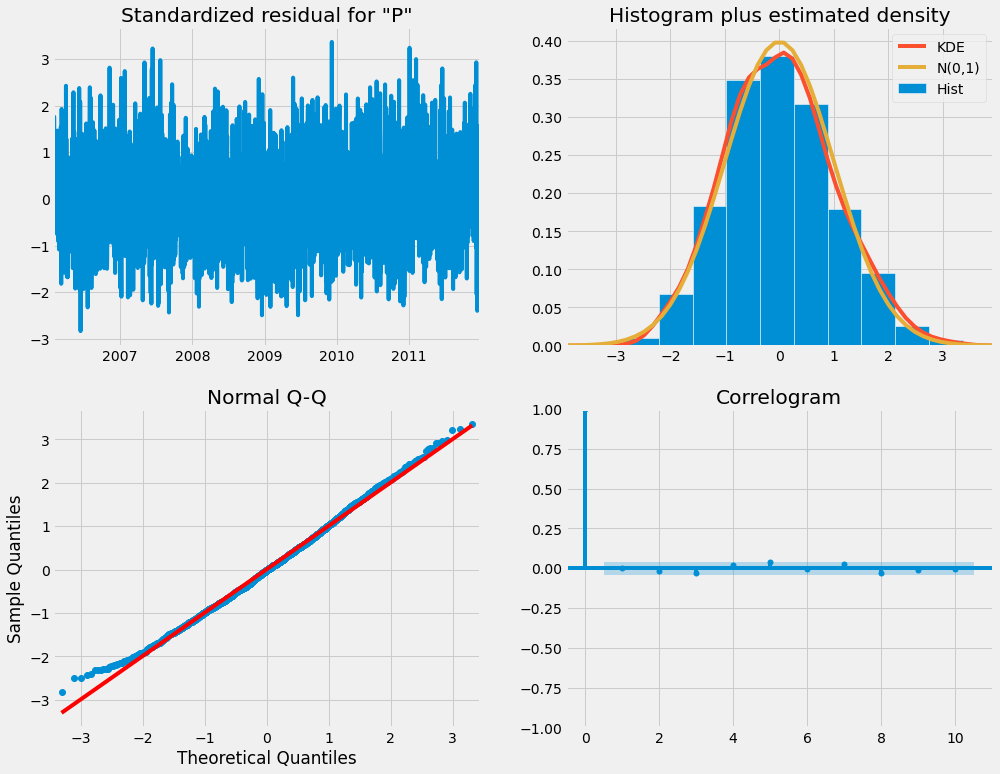

In [28]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [29]:
y.index = pd.to_datetime(y.index)
type(y.index)
print(y['2006-01-01':])

New_Date
2006-01-01    456.5020
2006-01-02    451.5200
2006-01-03    455.5840
2006-01-04    461.5225
2006-01-05    453.6000
                ...   
2011-12-27    467.7280
2011-12-28    465.1875
2011-12-29    454.7125
2011-12-30    456.4600
2011-12-31    450.3650
Name: PE, Length: 2191, dtype: float64


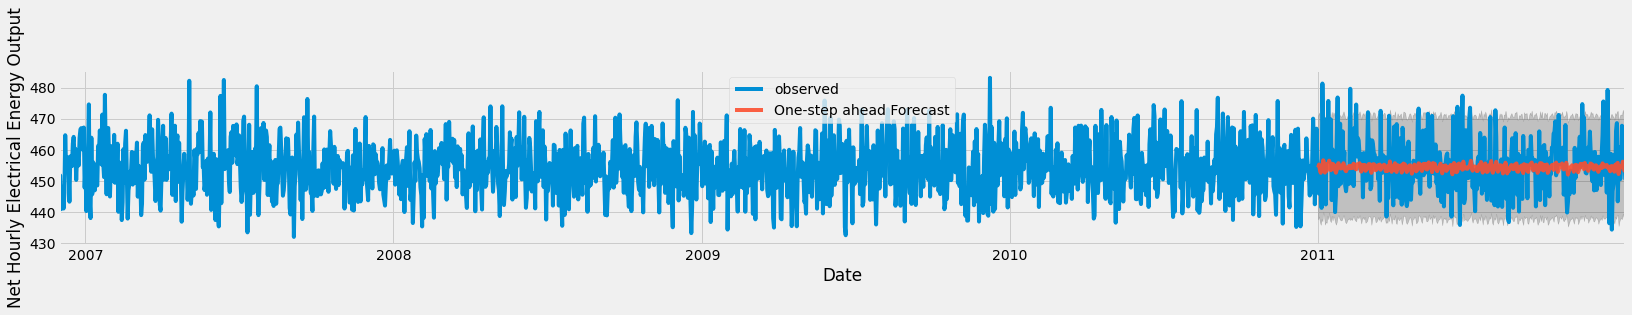

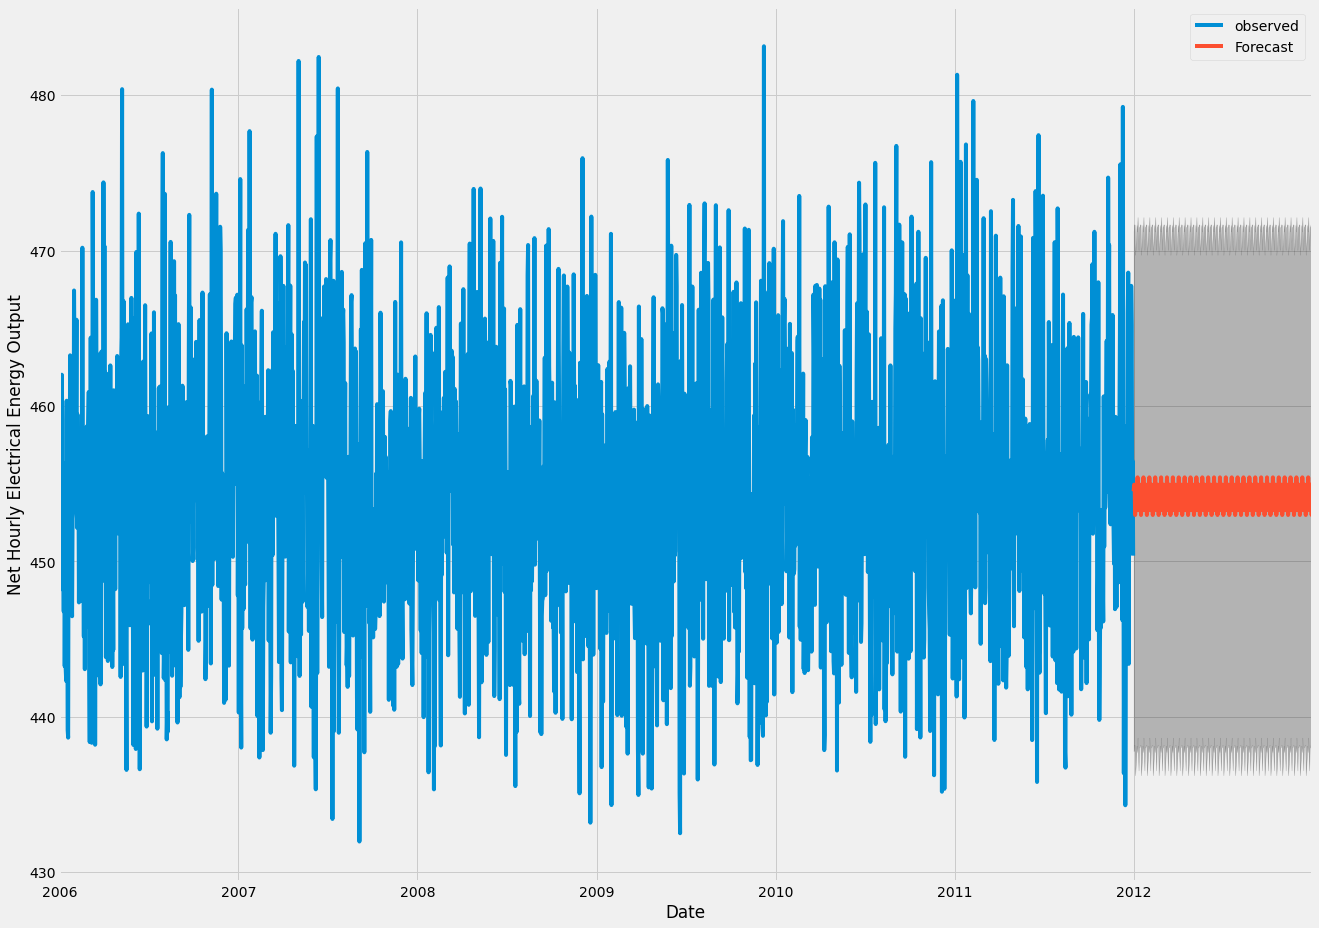

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2006-12-01':].plot(label='observed')
pred.predicted_mean.plot(label='One-step ahead Forecast', alpha=.9)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Net Hourly Electrical Energy Output')
plt.legend()

plt.show()
#-----------------
pred_uc = results.get_forecast(steps=365)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y['2006-01-01':].plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Net Hourly Electrical Energy Output')

plt.legend()
plt.show()

